In [1]:
# Set up existing models
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .
%pip install -U gdown

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (789/789), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 792 (delta 479), reused 749 (delta 470), pack-reused 3
Receiving objects: 100% (792/792), 54.99 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (479/479), done.
/content/semantic-segmentation
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=47845a2b38fbc4dfe48355b546e0a9da556da3f8ef09c1668fe1c2ef66029b20
  Stored in directory: /root/.cache/pip/w

In [2]:
# Custom imports: Dataset, Preprocessor, Dataloader, Training and Loss functions

import os
import sys
import torch
import numpy as np
from torch.utils.data import DataLoader

IN_COLAB = 'google.colab' in sys.modules

if not IN_COLAB:

    from git import Repo

    # Initialize the Git repository object
    repo = Repo(".", search_parent_directories=True)

    # Get the root directory of the Git project
    root_dir = repo.git.rev_parse("--show-toplevel")

    from pathlib import Path

    # Set up path for custom importer modules
    # Data Loader
    importer_module = root_dir + '/dataloader/'
    sys.path.insert(0, importer_module)
    from loader import Ai4MarsImporter, Ai4MarsProcessor, Ai4MarsData

    # Loss
    loss_module = root_dir + '/trainer/loss/'
    sys.path.insert(0, loss_module)
    import loss

    # Trainer
    trainer_module = root_dir + '/trainer/'
    sys.path.insert(0, trainer_module)
    from trainer import Ai4MarsTrainer

    # Insert here your local path to the dataset (temporary)
    data_path = data_path = input("Path to Dataset: ") #'/home/leeoos/Desktop/'

else: # IN_COLAB

    from google.colab import drive
    drive.mount('/content/drive')

    # On Colab the path to the module ti fixed once you have
    # corretly set up the project with gitsetup.ipynb

    # Import Loader
    fixed_path_loader = '/content/drive/MyDrive/Github/visiope/dataloader/'
    sys.path.insert(0, fixed_path_loader)
    from loader import Ai4MarsImporter, Ai4MarsProcessor, Ai4MarsData

    # Import Trainer
    fixed_path_trainer = '/content/drive/MyDrive/Github/visiope/trainer/'
    sys.path.insert(0,fixed_path_trainer )
    from trainer import Ai4MarsTrainer

    # Import Loss
    fixed_path_loss = '/content/drive/MyDrive/Github/visiope/trainer/loss/'
    sys.path.insert(0, fixed_path_loss)
    import loss

    # Get Dataset from original sources (slower)
    original_dataset = False

    if original_dataset:
        # Insert here the path to the dataset on your drive
        data_path = input("Path to Dataset: ") #'/content/drive/MyDrive/foo/'

    else: # get Dataset as np array

        if not(os.path.exists('/content/dataset/X.npy') and
               os.path.exists('/content/dataset/y.npy')):

            import gdown

            # get url of np dataset (temporarerly my drive)
            url_X = 'https://drive.google.com/uc?id=1HLAQgjZbGa3lMzdyIvgykCiUJ6P4OaEX'
            url_y = 'https://drive.google.com/uc?id=1Ue74LEe0WlEnFxRcIl19WyvXR1EyYIsS'

            # download np dataset on runtime env
            data_path = '/content/dataset/'
            gdown.download(url_X, data_path, quiet=False)
            gdown.download(url_y, data_path, quiet=False)
        pass

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


Downloading...
From (uriginal): https://drive.google.com/uc?id=1HLAQgjZbGa3lMzdyIvgykCiUJ6P4OaEX
From (redirected): https://drive.google.com/uc?id=1HLAQgjZbGa3lMzdyIvgykCiUJ6P4OaEX&confirm=t&uuid=b1381e7b-aaeb-482b-a3a7-73d9b1831d58
To: /content/dataset/X.npy
100%|██████████| 629M/629M [00:05<00:00, 113MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Ue74LEe0WlEnFxRcIl19WyvXR1EyYIsS
From (redirected): https://drive.google.com/uc?id=1Ue74LEe0WlEnFxRcIl19WyvXR1EyYIsS&confirm=t&uuid=15cf8673-acc3-4838-93f5-f195ad6502aa
To: /content/dataset/y.npy
100%|██████████| 210M/210M [00:01<00:00, 175MB/s]


In [3]:
from IPython.testing import test
# Build up Ai4MarsDataset

if not IN_COLAB or original_dataset:

    data_import = Ai4MarsImporter()

    X, y = data_import(path=data_path, num_of_images=200)

    processor = Ai4MarsProcessor(X, y)
    train_set, test_set, val_set = processor([0.54, 0.26, 0.20])

else:
    X = np.load('/content/dataset/X.npy')
    y = np.load('/content/dataset/y.npy')

    processor = Ai4MarsProcessor()
    train_set, test_set, val_set = processor(X, y, [0.54, 0.26, 0.20])


    # train_set = torch.load("/content/drive/MyDrive/Dataset/dataset/train.pt")
    # val_set = torch.load("/content/drive/MyDrive/Dataset/dataset/val.pt")
    # test_set = torch.load("/content/drive/MyDrive/Dataset/dataset/test.pt")



#COLPA MIAA (MY FAULT)!!!!!!!
# train_set.setDevice(device)
# val_set.setDevice(device)
# test_set.setDevice(device)

train_set.resize(64)
test_set.resize(64)
val_set.resize(64)

train_set.conversion('f')
test_set.conversion('f')
val_set.conversion('f')

train_set.set_grad()
test_set.set_grad()
val_set.set_grad()

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_set, batch_size=5, shuffle=True)

In [4]:
print(len(train_set))
print(len(train_loader))
print(train_loader.dataset.__getitem__(0)[0].shape)

108
2
torch.Size([3, 64, 64])


In [5]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


In [6]:
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT
From (redirected): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT&confirm=t&uuid=2b647f9d-6b62-4516-8d8c-e656d26795e9
To: /content/semantic-segmentation/checkpoints/pretrained/segformer/segformer.b3.ade.pth
100%|██████████| 190M/190M [00:03<00:00, 49.2MB/s]


'./checkpoints/pretrained/segformer/segformer.b3.ade.pth'

In [ ]:
#  Import segformer

from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B1',
    num_classes=5
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

model.to(device)

print('Loaded Model')
print(model.backbone)

In [ ]:
PATH = '/content/drive/MyDrive/Models/MiT-B0/state_dict'
if os.path.exists(PATH):
    state_dict = torch.load(PATH)
    model.load_state_dict(state_dict)
    # Compare the model's state with the loaded state
    wmatch = True
    for key in state_dict:
        if not torch.equal(model.state_dict()[key], state_dict[key]):
            match = False
            break

    if wmatch:
        print("State loaded successfully")
    else:
        print("State loading failed")

In [9]:
# control to delete
print(len(train_set))

image, label = train_loader.dataset.__getitem__(0)
print(image.requires_grad)

108
True


In [10]:
# test import trainer
loss_fn =  ...
optimizer = ...
training_set = ...
test_set =  ...

trainer = Ai4MarsTrainer(loss_fn, optimizer, training_set, test_set, device)

In [17]:
import sys
import torch
from pathlib import Path
from datetime import datetime

# This class collects all the training functionalities to train different models
class TmpTrainer():

    # Initialization of training parameters in the class constructor
    def __init__(self, loss_fn, optimizer, train_loader, test_loader,
                 device='cpu', save_state=None):
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.save_state = save_state

    # This function implements training for just one epoch
    def train_one_epoch(self, model, epoch_index=0):
        accumulated_loss = 0.
        last_loss = 0.

        for batch_index, batch in enumerate(self.train_loader):
            # Every data instance is an (input, label) pair
            inputs, labels = batch

            # Zero your gradients for every batch!
            self.optimizer.zero_grad()

            # Send inputs and labels to GPU
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            # Make predictions for this batch
            outputs = model(inputs)

            labels = labels.squeeze()
            labels = labels.long()

            # outputs = outputs.softmax(1).argmax(1).to(int)
            # outputs.unique()
            # labels = labels.squeeze()
            # labels = labels.type(torch.FloatTensor)
            # outputs = outputs.type(torch.FloatTensor)

            # print(outputs.requires_grad)
            # print(f'output shape: {outputs.shape}')
            # print(f'labels shape: {labels.shape}')

            # TEMPORARY MODIFICATIONS
            #NEED TO MODIFY FOR EACH MODEL, BASED ON LABEL!!!!!!!!!!!!
            # new_pred = torch.argmax(outputs, dim=1)
            '''outputs = torch.max(outputs, dim=1, keepdim=True)[0]'''
            # print(new_pred.requires_grad)
            # print(f'arg max shape: {new_pred.shape}')

            #new_pred = new_pred[None, :, :, :] FOR MODEL -> UNKNOWN
            # new_pred = new_pred.unsqueeze(1)
            # new_pred = new_pred[:, None, :, :]
            # print(new_pred.requires_grad)
            # new_pred = new_pred.type(torch.float32)
            # print(f'squeeze shape: {new_pred.shape}')
            # END OF TEMPORARY MODIFICATIONS

            # print(new_pred.requires_grad)
            #new_pred.requires_grad = True

            # Compute the loss and its gradients
            loss = self.loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            self.optimizer.step()

            accumulated_loss += loss.item()
            #report_index = len(self.train_loader) -1

            # Free VRAM
            inputs.detach()
            labels.detach()
            del inputs
            del labels

        # Compute the average loss over all batches
        last_loss =  accumulated_loss / batch_index+1

        # Print report at the end of the last batch
        print(f'Epoch {epoch_index+1} loss: {last_loss}')

        return last_loss

    # This function implements training for multiple epochs
    def train_multiple_epoch(self, model, EPOCHS=100):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        epoch_number = 0 # just a counter
        best_tloss = 1_000_000.

        for epoch in range(EPOCHS):
            print(f'EPOCH: {epoch+1}')

            # Make sure gradient tracking is on, and do a pass over the data
            model.train(True)
            avg_loss = self.train_one_epoch(model, epoch)

            # We don't need gradients on to do reporting
            # model.train(False)

            # Test loss
            accumulated_tloss = 0.0
            for tbatch_index, tbatch in enumerate(self.test_loader):

                # Every data instance is a (input, label) pair
                tinputs, tlabels = tbatch

                # Send inputs and labels to GPU
                tinputs = tinputs.to(self.device)
                tlabels = tlabels.to(self.device)

                # Model prediction
                toutputs = model(tinputs)

                tlabels = tlabels.squeeze()
                tlabels = tlabels.long()

                # Run test loss
                test_loss = self.loss_fn(toutputs, tlabels)
                accumulated_tloss += test_loss.item()

                tinputs.detach()
                tlabels.detach()
                del tinputs
                del tlabels

            # Compute the average loss over all batches
            avg_tloss = accumulated_tloss / (tbatch_index + 1)

            # Print report at the end of the epoch
            print(f'LOSS train {avg_loss} test {avg_tloss}')

            # Track best performance, and save the model's state
            if avg_tloss < best_tloss:
                best_tloss = avg_tloss
                model_path = 'model_{}_{}'.format(timestamp, epoch_number)
                torch.save(model.state_dict(), model_path)

        if self.save_state:
            print(f'Saving model state in: {self.save_state}')
            torch.save(model.state_dict(), self.save_state)


if __name__ == '__main__':
    pass

In [18]:
# Define training parameters
loss_fn =  torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training_set = train_loader
test_set =  test_loader

trainer = TmpTrainer(loss_fn, optimizer, training_set, test_set, device, save_state='/content/state_dict')

In [ ]:
# START TRAIN
trainer.train_multiple_epoch(model, EPOCHS=100)

image shape: torch.Size([5, 64, 64, 3])


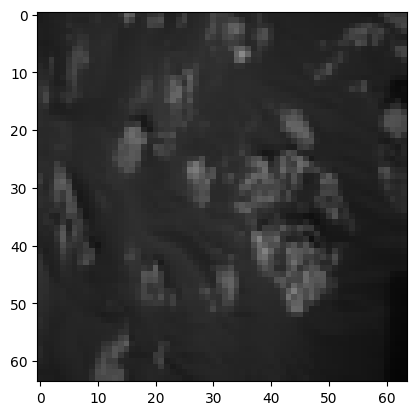

label shape: torch.Size([5, 64, 64, 1])


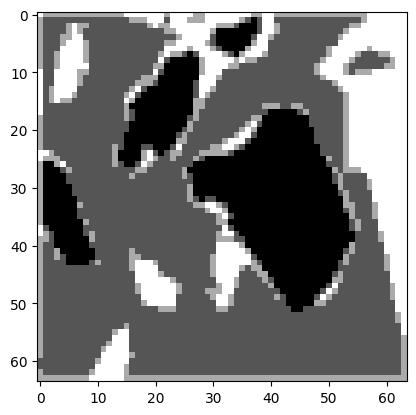

torch.Size([5, 5, 64, 64])
torch.Size([5, 64, 64])
loss : 3.694282054901123
pred shape: torch.Size([5, 64, 64, 3])


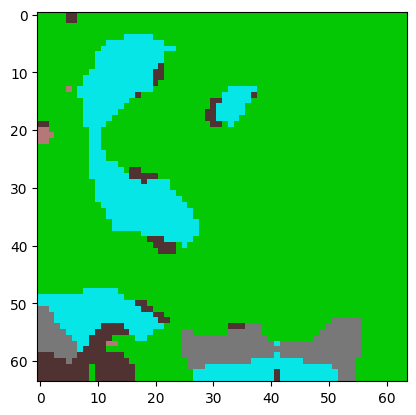

In [20]:
import matplotlib.pyplot as plt

val_set.resize(64)
val_loader = DataLoader(val_set, batch_size=5, shuffle=True)
image, label = next(iter(val_loader))

print(f'image shape: {image.permute(0,2,1,3).permute(0,1,3,2).shape}')
plt.imshow(image[0].permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

print(f'label shape: {label.permute(0,2,1,3).permute(0,1,3,2).shape}')
plt.imshow(label[0].permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

image = image.to(device)
label = label.to(device)

pred = model(image)

label = label.squeeze()
label = label.long()

print(pred.shape)
print(label.shape)

# label = label.type(torch.FloatTensor)
# pred = pred.type(torch.FloatTensor)

'''
The cross-entropy loss function will compute the element-wise softmax activation on the prediction
tensor along the class dimension to convert it into a probability distribution. It will then compare
this predicted probability distribution with the ground truth labels using the negative
log-likelihood loss calculation.

Therefore, even though the dimensions of the prediction and label tensors differ, the cross-entropy
loss function in PyTorch will appropriately handle the discrepancy and calculate the loss on a
per-pixel basis.
'''

print(f'loss : {loss_fn(pred, label)}')


pred = pred.softmax(1).argmax(1).to(int)
pred.unique()

from semseg.datasets import *
palette = eval('ADE20K').PALETTE
seg_map = palette[pred.cpu()].squeeze().to(torch.uint8)

print(f'pred shape: {seg_map.shape}')
plt.imshow(seg_map[0], cmap='gray')
plt.show()


# # print(label.type())
# label = label.type(torch.FloatTensor)
# # print(label.type())

# print(f'pred shape: {pred.shape}')
# print(f'label shape: {label.shape}')

# plt.imshow(pred[0].cpu().detach().numpy(), cmap='gray')
# plt.show()

# s = torch.nn.Softmax(dim=1)
# new_pred = prediction.permute(0,2,1,3).permute(0,1,3,2)
# label = label.permute(0,2,1,3).permute(0,1,3,2)

# print()
# print(f'pred shape {new_pred.shape}')
# print(f'label shape {label.shape}')

# print(new_pred[0].argmax(dim=-1))
# print(label.squeeze(dim=-1)[0])

# print()
# # new_pred = new_pred.max(dim=-1)[0]
# new_pred = new_pred.to(device)
# label = label.to(device)

# print(f'pred shape {new_pred[0].shape}')
# print(f'label shape {label[0].shape}')

# print(f'pred shape {new_pred[0].shape}')

# print(loss_fn(new_pred, label))

# print(prediction.shape)
# new_prediction = torch.argmax(prediction, dim=1)
# print(f"prediction BEFORE shape -> {new_prediction.shape}")

# new_prediction = new_prediction[:,None, :, :]
# print(f"prediction AFTER shape -> {new_prediction.shape}")
# print(f"label shape -> {label.shape}")

# print(new_prediction.type())
# new_prediction = new_prediction.type(torch.FloatTensor)
# print(label.type())

# print(loss_fn(new_prediction, label))

image.detach()
label.detach()
del label
del image
